In [1]:

from experiment_information import *
from data import *
from util import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


In [2]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)
# print("Current code version, ", __version__)

In [3]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "52"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,ps,dp,d,p,erm_methods,completed,data_model_type
164,25b41aaf-f579-47d4-a421-5ff2a8c8aa03,Vanilla Strong Weak Trials,40.324946,53,2023-10-04 14:21:35,1,3,"[0.1, 2.575, 5.05, 7.525, 10.0]",[0],[0.01],[0.0],[0.75],0.01,1000,1000,"[""sklearn""]",1,RandomKitchenSink
163,6a16791a-8f3c-403e-85f1-9a7858b2cb43,Vanilla Strong Weak Trials,35.432323,53,2023-10-04 14:19:45,1,3,"[0.1, 2.575, 5.05, 7.525, 10.0]",[0],[0.01],[0.0],[0.75],0.01,1000,1000,"[""sklearn""]",1,RandomKitchenSink
162,91c28d1c-4c64-473f-ac53-10cb687fd69b,Vanilla Strong Weak Trials,36.733035,53,2023-10-04 14:14:12,1,3,"[0.1, 2.575, 5.05, 7.525, 10.0]",[0],[0.01],[0.0],[0.75],0.01,1000,1000,"[""sklearn""]",1,RandomKitchenSink


In [4]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [5]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[1]["experiment_id"]
print(experiment_id)
# experiment_id = "031d5eb9-bf79-4ffb-9fb3-eabedcd350b0"

# This guy was interesting in version 25 for the q- state evolution adaptation
# a2a3016c-8264-4599-ac8f-b457da2790ba
# this guy is interesting in version 28! q-state evolution - best erm so far, close call
# b5f9faf7-ec66-490c-ac99-841888f3fedf
# experiment_id = "b5f9faf7-ec66-490c-ac99-841888f3fedf"
# version 30: 7b921b61-0b48-48a8-8ead-78bc5804597f - q state evolution. Overlaps match except for lambda = 1 in the settings tau=0,2, lam=5*1e-5 for epsilon up to 0.7
# version 30: f92b13d1-c020-46c0-a3cd-5e0578b831a5 - Q state evolution. Same setting as above but not matching overlap.

# version 36 on cluster: 58b544ab-3536-4eb7-bbb9-743f471f6bb3

6a16791a-8f3c-403e-85f1-9a7858b2cb43


In [6]:
round_to = 1
def my_floor(a, precision=round_to):
    return np.round(a - 0.5 * 10**(-precision), precision)
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: my_floor(x,precision=round_to))
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam"]) #,"p"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam"]) #,"p"
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error"]] #,"calibration"
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d", "training_loss","test_loss","adversarial_generalization_error_erm","adversarial_generalization_error_overlap"]] #"erm_calibration","analytical_calibration"
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm_erm","training_error_state_evolution"]] # ,"erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution"
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3]).agg([np.mean,np.std]) #,4
# display all columns
pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_23334/2243696617.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))


generalization_error_state_evolution       \
                                                       mean  std   
alpha epsilon tau lam                                              
0.0   0.0     0.0 0.01                             0.421646  0.0   
2.5   0.0     0.0 0.01                             0.149854  0.0   
5.0   0.0     0.0 0.01                             0.089022  0.0   
7.5   0.0     0.0 0.01                             0.065039  0.0   
10.0  0.0     0.0 0.01                             0.052584  0.0   

                       generalization_error_erm_erm            \
                                               mean       std   
alpha epsilon tau lam                                           
0.0   0.0     0.0 0.01                     0.424400  0.007418   
2.5   0.0     0.0 0.01                     0.145067  0.004922   
5.0   0.0     0.0 0.01                     0.082300  0.008707   
7.5   0.0     0.0 0.01                     0.061667  0.002344   
10.0  0.0     0.0 0.01                     0.050133  0.001626   

                       generalization_error_overlap_erm            \
                                                   mean       std   
alpha epsilon tau lam                                               
0.0   0.0     0.0 0.01                         0.424569  0.002853   
2.5   0.0     0.0 0.01                         0.149388  0.007115   
5.0   0.0     0.0 0.01                         0.083123  0.003466   
7.5   0.0     0.0 0.01                         0.061662  0.004260   
10.0  0.0     0.0 0.01                         0.053039  0.001355   

                       sigma_state_evolution      q_state_evolution       \
                                        mean  std              mean  std   
alpha epsilon tau lam                                                      
0.0   0.0     0.0 0.01             93.053312  0.0          1.162281  0.0   
2.5   0.0     0.0 0.01             18.696532  0.0         27.183155  0.0   
5.0   0.0     0.0 0.01              8.017317  0.0         45.743860  0.0   
7.5   0.0     0.0 0.01              4.909224  0.0         59.639582  0.0   
10.0  0.0     0.0 0.01              3.534923  0.0         71.002812  0.0   

                            Q_erm           m_state_evolution          m_erm  \
                             mean       std              mean  std      mean   
alpha epsilon tau lam                                                          
0.0   0.0     0.0 0.01   1.254351  0.038004          0.262707  0.0  0.269163   
2.5   0.0     0.0 0.01  27.267362  0.651049          4.646566  0.0  4.714190   
5.0   0.0     0.0 0.01  46.083277  0.913222          6.500640  0.0  6.554194   
7.5   0.0     0.0 0.01  61.102516  0.423742          7.562021  0.0  7.712885   
10.0  0.0     0.0 0.01  73.718952  0.869783          8.311598  0.0  8.399308   

                                 cosb_state_evolution       cosb_erm  \
                             std                 mean  std      mean   
alpha epsilon tau lam                                                  
0.0   0.0     0.0 0.01  0.008602             0.243678  0.0  0.234757   
2.5   0.0     0.0 0.01  0.075515             0.891214  0.0  0.891729   
5.0   0.0     0.0 0.01  0.201339             0.961147  0.0  0.966058   
7.5   0.0     0.0 0.01  0.172672             0.979198  0.0  0.981237   
10.0  0.0     0.0 0.01  0.199373             0.986386  0.0  0.986144   

                                   rho_erm            \
                             std      mean       std   
alpha epsilon tau lam                                  
0.0   0.0     0.0 0.01  0.008709  1.049518  0.053340   
2.5   0.0     0.0 0.01  0.010019  1.026274  0.061569   
5.0   0.0     0.0 0.01  0.002842  0.999270  0.053232   
7.5   0.0     0.0 0.01  0.002627  1.011340  0.038126   
10.0  0.0     0.0 0.01  0.000701  0.984587  0.049387   

                       training_loss_state_evolution      training_loss_erm  \
                                                m

In [7]:
def extract_optimal_lambda(alpha, epsilon, tau, recursion_depth = 0):
    # extract or compute optimal lamba and plot it as a vertical line
    filename = f"experiments/optimal_lambdas.csv"
    # read filename as pandas dataframe
    df_optimal_lambdas = pd.read_csv(filename)
    # filter the dataframe for the current value of tau, epsilon and alpha
    optimal_lambdas_subset = df_optimal_lambdas[(df_optimal_lambdas["tau"] == tau) & (df_optimal_lambdas["epsilon"] == epsilon) & (df_optimal_lambdas["alpha"] == alpha)]
    # extract the optimal lambda
    try:
        optimal_lambda = optimal_lambdas_subset["lambda"].values[0]
        return optimal_lambda
    except:
        if recursion_depth > 0:
            return None
        print("Optimal lambda not found. Computing it now.")
        command = f"python optimal_choice.py {alpha} {epsilon} {tau}"
        import subprocess
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        process.wait()
        return extract_optimal_lambda(alpha,epsilon,tau,recursion_depth=recursion_depth+1)

In [8]:
first_iteration = "tau"
second_iteration = None # "lam"
target = "alpha"
sweep = "epsilon"
def create_plot(df, error_name, state_evolution_name, gd_name, log_x = False, log_y=False, fix_a_variable = None, variable_value = None, filename=None):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    for tau in df2[first_iteration].unique():

        iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

        for lam in iterate_over:

            # Filter the dataframe for the current values of tau and lam
            if second_iteration is None:
                data = df2[(df2[first_iteration] == tau)]
            else:
                data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam)]

            if fix_a_variable is not None:
                data = data[data[fix_a_variable] == variable_value]
            
            for i, epsilon in enumerate(data[sweep].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data[sweep] == epsilon]

                # Plot the state_evolution results as a line
                if state_evolution_name is not None:
                    if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                        plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon}', color=palette[i])
                    else:
                        plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                if gd_name is not None:
                    try:
                        plt.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                    except:
                        pass

                if error_name == "Generalization Error" and target == "lam":
                    optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau)
                    # plot the optimal lambda as a vertical line
                    plt.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

            
            if log_x:
                plt.xscale('log')
            if log_y:
                plt.yscale('log')

            # Add labels and title
            plt.xlabel(target)
            plt.ylabel(error_name)
            if fix_a_variable is not None:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d} - {fix_a_variable}: {variable_value}')
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}')
            else:
                if second_iteration is None:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, d: {d}')
                else:
                    plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d}')
            # Add a legend
            plt.legend()

            # add a grid
            plt.grid()

            plt.tight_layout()

            if fix_a_variable is not None:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
            else:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
            # Save the plot as svg
            if filename is not None:
                plt.savefig(f"Assets/{filename}_{name}.pdf", bbox_inches='tight')

            # Show the plot
            plt.show()

In [9]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

In [10]:
# create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


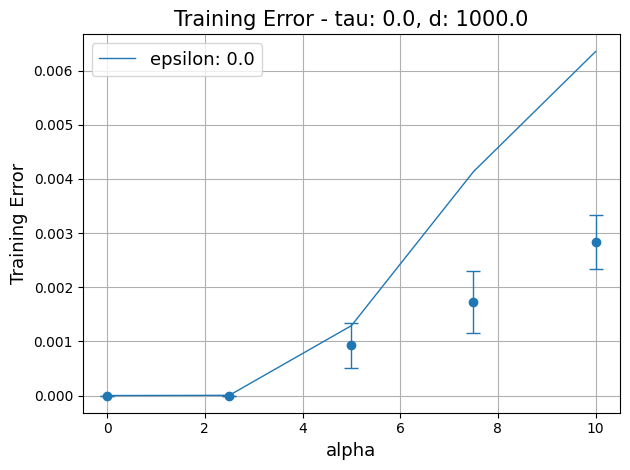

In [11]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm",log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


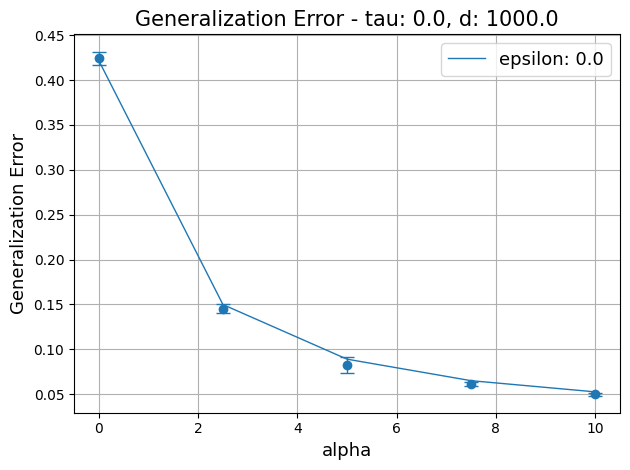

In [12]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


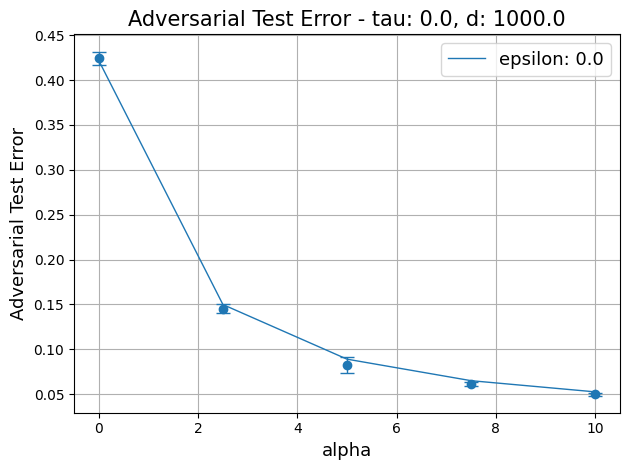

In [13]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm_erm",log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


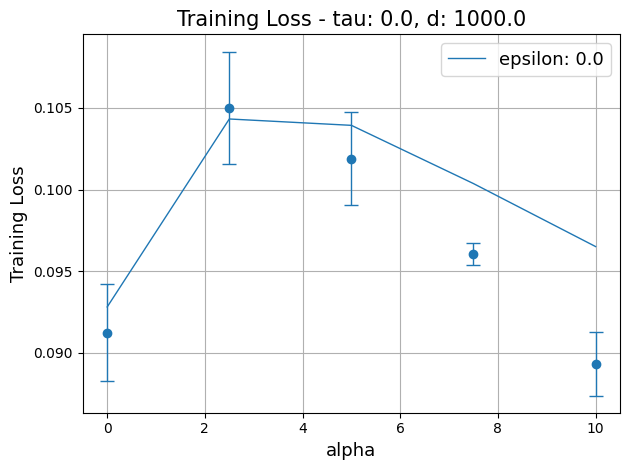

In [14]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


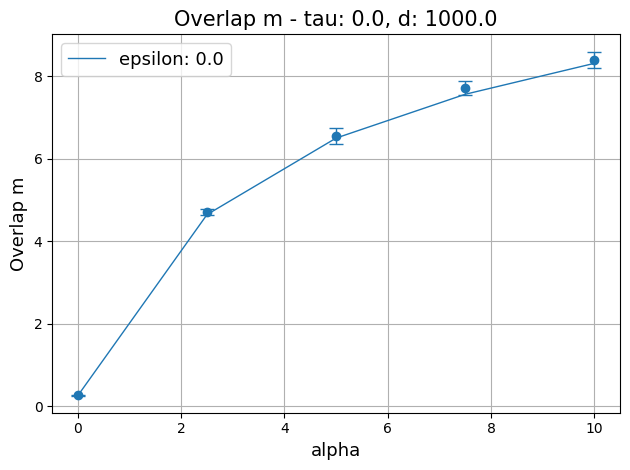

In [15]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


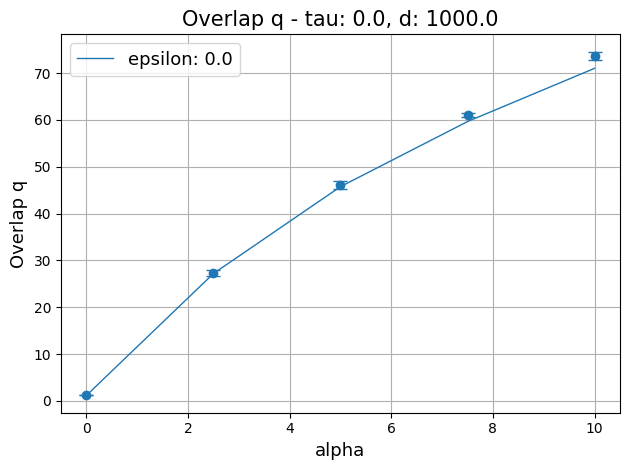

In [16]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


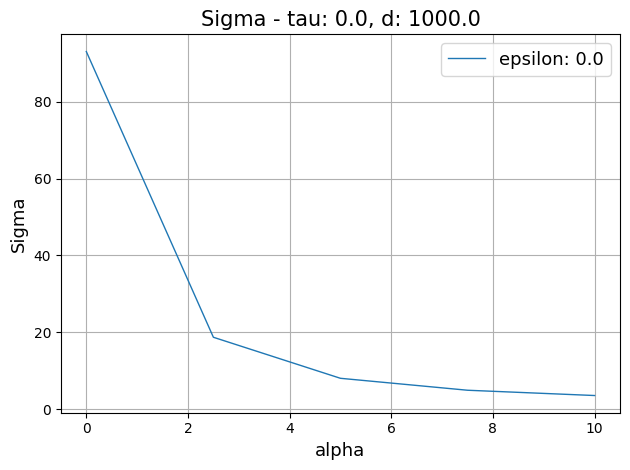

In [17]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None, log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


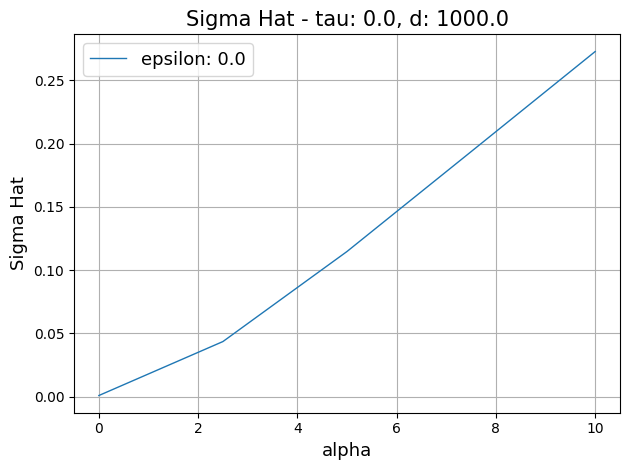

In [18]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None, log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


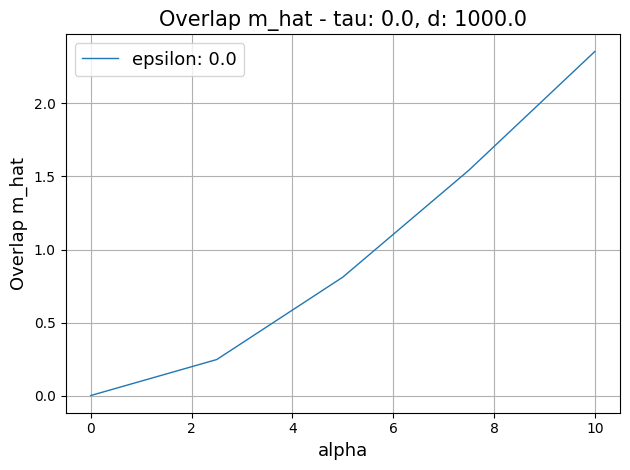

In [19]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None, log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


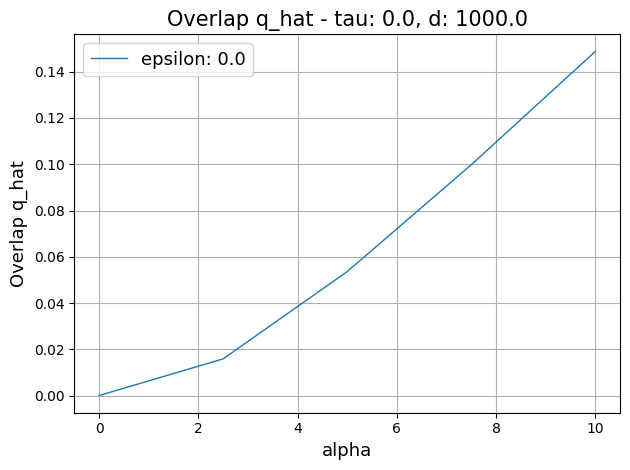

In [20]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None, log_y=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


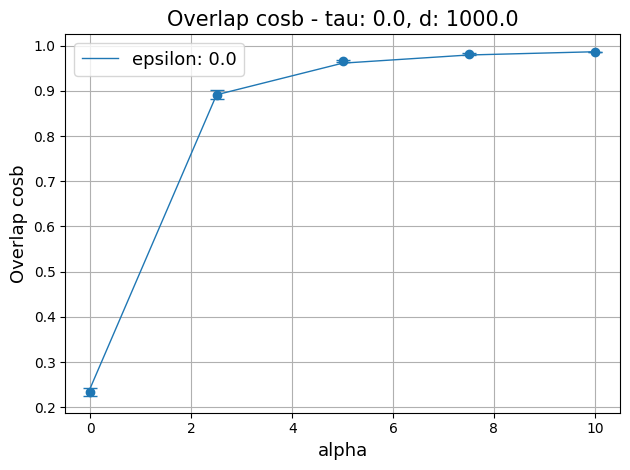

In [21]:
create_plot(df, "Overlap cosb", "cosb_state_evolution","cosb_erm",log_y=False)

In [22]:
# subset df to keep only where p = 0.5
# p = 0.75
# dfp = df[df.index.get_level_values("p") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


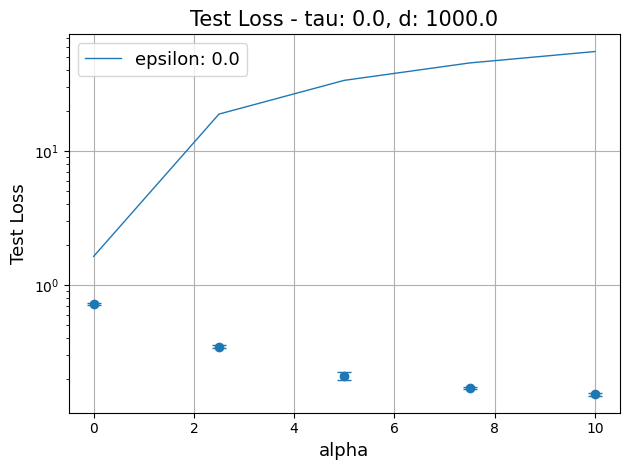

In [23]:
# plot test loss erm
create_plot(df, "Test Loss", "estimation_error_state_evolution","test_loss_erm",log_y=True)

In [24]:
# plot estimation_error_state_evolution
# create_plot(df, "Estimation Error", "estimation_error_state_evolution",None,log_y=True)

## Log-Log Plots of overlaps in State_evolution

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


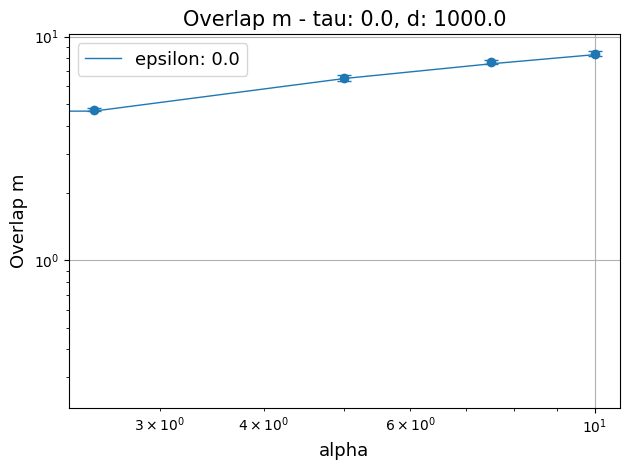

In [25]:
# create a log-log plot of the overlap m
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_x=True, log_y=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


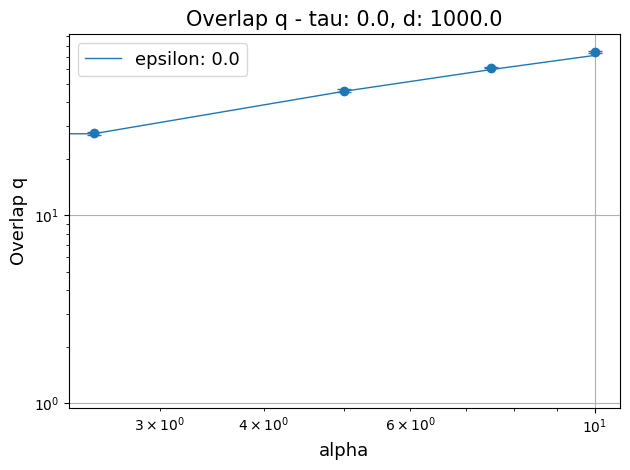

In [26]:
# create a log-log plot of the overlap q
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_x=True, log_y=True)

In [27]:
# create a log-log plot of the overlap sigma
# create_plot(df, "Overlap sigma", "sigma_state_evolution",None, log_x=True, log_y=True)

In [28]:
# create a log-log plot of the overlap sigma_hat
# create_plot(df, "Overlap sigma_hat", "sigma_hat_state_evolution",None, log_x=True, log_y=True)

In [29]:
# create a log-log plot of the overlap q_hat
# create_plot(df, "Overlap q_hat", "q_hat_state_evolution",None, log_x=True, log_y=True)

In [30]:
# create a log-log plot of the overlap m_hat
# create_plot(df, "Overlap m_hat", "m_hat_state_evolution",None, log_x=True, log_y=True)